In [1]:
!pip install nodevectors
!pip install umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# This code is inspired by https://github.com/VHRanger/nodevectors

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

import warnings
warnings.simplefilter("ignore")

import requests
import gzip
import io
import gc
import networkx as nx
import numpy as np
import pandas as pd
import time
import scipy
import sklearn
from sklearn import cluster, linear_model
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
import copy
import random
import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, average_precision_score,
     f1_score, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier

import nodevectors
import csrgraph as cg
from csrgraph import methods
from nodevectors.evaluation import link_pred
from nodevectors.evaluation import graph_eval
import umap
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def nx_node_weights(G, method, **kwargs):
    """Node weights using networkX API"""
    pr = np.zeros(len(G))
    prdict = method(G, **kwargs)
    for i in G.nodes:
        pr[i] = prdict[i]
    return pr

In [3]:
res = requests.get('http://snap.stanford.edu/data/email-Eu-core.txt.gz', verify=False)
edges = gzip.GzipFile(fileobj=io.BytesIO(res.content))
edges = pd.read_csv(io.StringIO(edges.read().decode()), header=None, sep=' ')
edges.columns = ['src', 'dest']

# cluster labels per node
res = requests.get('http://snap.stanford.edu/data/email-Eu-core-department-labels.txt.gz', verify=False)
labels = gzip.GzipFile(fileobj=io.BytesIO(res.content))
labels = pd.read_csv(io.StringIO(labels.read().decode()), header=None, sep=' ')
labels.columns = ['node', 'cluster']
G = nx.Graph()
G.add_edges_from([(t.src, t.dest) for t in edges.itertuples()])
labels= pd.DataFrame({'node': list(G), 'label': labels.cluster})

In [4]:
#### CONFIG
N_COMPONENTS = 32 # resulting embedding dim
SEED = 42 # RNG Seed
TEST_SIZE = 0.2

# For resampling tests
RESAMPLE_WALKS = 10
RESAMPLE_LEN = 6

In [5]:
#### For Link Prediction: Split graph into train and test edge sets
#### (All nodes are still present in both)
G_train, testing_pos_edges = link_pred.split_train_test_graph(G, testing_ratio=TEST_SIZE)

#### Lazy way to set up evaluation
try:
    y = labels.label
    n_clusters = y.nunique()
    HAS_LABELS = True
    print(f"clusters: {n_clusters}")
except:
    try: # Multilabels 
        y = MultiLabelBinarizer().fit_transform(mlabels.mlabels)
        HAS_LABELS = True
        print(f"multilabels: {y.shape[1]}")
    except: # No Labels
        HAS_LABELS = False
        print("No Labels")
NNODES = len(G)
print(f"Nodes: {NNODES}\nEdges: {len(G.edges)}\nconnected: {nx.is_connected(G_train)}")

clusters: 42
Nodes: 1005
Edges: 16706
connected: False


In [6]:
def split_train_test_graph(G, testing_ratio=0.5, seed=42):
    node_num1, edge_num1 = len(G.nodes), len(G.edges)
    testing_edges_num = int(len(G.edges) * testing_ratio)
    random.seed(seed)
    testing_pos_edges = random.sample(G.edges, testing_edges_num)
    G_train = copy.deepcopy(G)
    G_train.remove_nodes_from(testing_pos_edges)
    G_train.remove_nodes_from(nx.isolates(G_train))
    node_num2, edge_num2 = len(G_train.nodes), len(G_train.edges)
    assert node_num1 == node_num2
    return G_train, testing_pos_edges

In [7]:
def generate_neg_edges(G, testing_edges_num, seed=42):
    nnodes = len(G.nodes)
    # Make a full graph (matrix of 1)
    negG = np.ones((nnodes, nnodes))
    np.fill_diagonal(negG, 0.)
    # Substract existing edges from full graph
    # generates negative graph
    original_graph = nx.adj_matrix(G).todense()
    negG = negG - original_graph
    # get negative edges (nonzero entries)
    neg_edges = np.where(negG > 0)
    random.seed(seed) # replicability!
    rng_edges = random.sample(range(neg_edges[0].size), testing_edges_num)
    # return edges in (src, dst) tuple format
    return list(zip(
        neg_edges[0][rng_edges],
        neg_edges[1][rng_edges]
    ))

In [8]:
def link_prediction(p, q, embedding, G, train_G, test_pos_edges, seed=42):
    print("Link Prediction:")
    train_neg_edges = generate_neg_edges(G, len(train_G.edges()), seed)
    random.seed(seed)
    # create a auxiliary graph to ensure that testing 
    #    negative edges will not used in training
    G_aux = copy.deepcopy(G)
    G_aux.add_edges_from(train_neg_edges)
    test_neg_edges = generate_neg_edges(G_aux, len(test_pos_edges), seed)

    # construct X_train, y_train, X_test, y_test
    X_train = []
    y_train = []
    for e in train_G.edges():
        feature_vector = np.append(embedding[e[0]], embedding[e[1]])
        X_train.append(feature_vector)
        y_train.append(1)
    for e in train_neg_edges:
        feature_vector = np.append(embedding[e[0]], embedding[e[1]])
        X_train.append(feature_vector)
        y_train.append(0)

    X_test = []
    y_test = []
    for e in test_pos_edges:
        feature_vector = np.append(embedding[e[0]], embedding[e[1]])
        X_test.append(feature_vector)
        y_test.append(1)
    for e in test_neg_edges:
        feature_vector = np.append(embedding[e[0]], embedding[e[1]])
        X_test.append(feature_vector)
        y_test.append(0)

    # shuffle for training and testing
    c = list(zip(X_train, y_train))
    #random.shuffle(c)
    X_train, y_train = zip(*c)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    c = list(zip(X_test, y_test))
    #random.shuffle(c)
    X_test, y_test = zip(*c)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Logistic regression
    lr_m = LogisticRegression(random_state=seed, solver='lbfgs')
    lr_m.fit(X_train, y_train)
    y_pred_proba = lr_m.predict_proba(X_test)[:, 1]
    y_pred = lr_m.predict(X_test)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_pr = average_precision_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\t(logit) AUC-ROC: {auc_roc:.3f}, AUC-PR: {auc_pr:.3f}, "
          f"Acc: {accuracy:.3f}, F1: {f1:.3f}")
    
    # Light GBM
    import lightgbm as lgbm
    gbm_m = lgbm.LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=15,
        max_depth=3,
        learning_rate=0.25,
        n_estimators=50,
        subsample_for_bin=30,
        objective='mse',
        min_split_gain=0.001,
        min_child_weight=0.001,
        min_child_samples=15,
        importance_type='gain',
    )
    gbm_m.fit(X_train, y_train)
    y_pred_proba = gbm_m.predict_proba(X_test)[:, 1]
    y_pred = gbm_m.predict(X_test)
    auc_roc2 = roc_auc_score(y_test, y_pred_proba)
    auc_pr2 = average_precision_score(y_test, y_pred_proba)
    accuracy2 = accuracy_score(y_test, y_pred)
    f12 = f1_score(y_test, y_pred)
    print(f"\t(lgbm)  AUC-ROC: {auc_roc2:.3f}, AUC-PR: {auc_pr2:.3f}, "
          f"Acc: {accuracy2:.3f}, F1: {f12:.3f}")
    
    # Random Forest
    rf_m = RandomForestClassifier(random_state=seed)
    rf_m.fit(X_train, y_train)
    y_pred_proba = rf_m.predict_proba(X_test)[:, 1]
    y_pred = rf_m.predict(X_test)
    auc_roc3 = roc_auc_score(y_test, y_pred_proba)
    auc_pr3 = average_precision_score(y_test, y_pred_proba)
    accuracy3 = accuracy_score(y_test, y_pred)
    f13 = f1_score(y_test, y_pred)
    print(f"\t(logit) AUC-ROC: {auc_roc:.3f}, AUC-PR: {auc_pr:.3f}, "
          f"Acc: {accuracy:.3f}, F1: {f1:.3f}")
    
    lr_result = {"p":p, "q": q, "model": 'Logistic Regression', "auc_roc": auc_roc, "auc_pr" : auc_pr, "accuracy" : accuracy, "f1" : f1}
    gbm_result = {"p":p, "q": q, "model": 'Light GBM', "auc_roc": auc_roc2, "auc_pr" : auc_pr2, "accuracy" : accuracy2, "f1" : f12}
    rf_result = {"p":p, "q": q, "model": 'Random Forest', "auc_roc": auc_roc3, "auc_pr" : auc_pr3, "accuracy" : accuracy3, "f1" : f13}

    return lr_result, gbm_result, rf_result

Creating 32 dimension embedding by implementing Node2vec. Quantifying the embedding quality using logistic regression, lightGBM and random forest. 

In [9]:
result_df = pd.DataFrame(columns = ['p', 'q', 'model', 'auc_roc','auc_pr', "accuracy", "f1"])
return_weight_values = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
neighbor_weight_values = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]

for r in tqdm(return_weight_values):
  for n in neighbor_weight_values:
    n2v_params = dict(
        n_components=N_COMPONENTS,
        epochs=20,
        walklen=60,
        return_weight=r,
        neighbor_weight=n,
        w2vparams={
            "window":3, 
            "negative":5, 
            "iter":2,
            "batch_words":128}
    )

    start_t = time.time()
    w_train = nodevectors.Node2Vec(**n2v_params).fit_transform(G_train)
    print(f"Time: {time.time() - start_t :.4f}")
    lr_result,  gbm_result, rf_result = link_prediction(r, n, w_train, G, G_train, testing_pos_edges)
    result_df = result_df.append(lr_result, ignore_index = True)
    result_df = result_df.append(gbm_result, ignore_index = True)
    result_df = result_df.append(rf_result, ignore_index = True)


  0%|          | 0/10 [00:00<?, ?it/s]

Making walks... Done, T=52.44
Mapping Walk Names... Done, T=1.39
Training W2V... Done, T=5.12
Time: 59.0424
Link Prediction:
	(logit) AUC-ROC: 0.771, AUC-PR: 0.794, Acc: 0.710, F1: 0.705
	(lgbm)  AUC-ROC: 0.951, AUC-PR: 0.940, Acc: 0.890, F1: 0.893
	(logit) AUC-ROC: 0.771, AUC-PR: 0.794, Acc: 0.710, F1: 0.705
Making walks... Done, T=29.06
Mapping Walk Names... Done, T=1.53
Training W2V... Done, T=5.09
Time: 35.7461
Link Prediction:
	(logit) AUC-ROC: 0.762, AUC-PR: 0.781, Acc: 0.710, F1: 0.705
	(lgbm)  AUC-ROC: 0.956, AUC-PR: 0.948, Acc: 0.892, F1: 0.894
	(logit) AUC-ROC: 0.762, AUC-PR: 0.781, Acc: 0.710, F1: 0.705
Making walks... Done, T=29.78
Mapping Walk Names... Done, T=1.39
Training W2V... Done, T=5.13
Time: 36.3474
Link Prediction:
	(logit) AUC-ROC: 0.755, AUC-PR: 0.776, Acc: 0.700, F1: 0.691
	(lgbm)  AUC-ROC: 0.955, AUC-PR: 0.947, Acc: 0.892, F1: 0.895
	(logit) AUC-ROC: 0.755, AUC-PR: 0.776, Acc: 0.700, F1: 0.691
Making walks... Done, T=40.38
Mapping Walk Names... Done, T=1.35
Tr

 10%|█         | 1/10 [10:18<1:32:43, 618.22s/it]

	(logit) AUC-ROC: 0.774, AUC-PR: 0.781, Acc: 0.707, F1: 0.697
Making walks... Done, T=28.27
Mapping Walk Names... Done, T=1.37
Training W2V... Done, T=5.11
Time: 34.9191
Link Prediction:
	(logit) AUC-ROC: 0.769, AUC-PR: 0.791, Acc: 0.712, F1: 0.707
	(lgbm)  AUC-ROC: 0.954, AUC-PR: 0.945, Acc: 0.888, F1: 0.891
	(logit) AUC-ROC: 0.769, AUC-PR: 0.791, Acc: 0.712, F1: 0.707
Making walks... Done, T=29.01
Mapping Walk Names... Done, T=1.39
Training W2V... Done, T=5.07
Time: 35.5151
Link Prediction:
	(logit) AUC-ROC: 0.762, AUC-PR: 0.782, Acc: 0.708, F1: 0.699
	(lgbm)  AUC-ROC: 0.958, AUC-PR: 0.948, Acc: 0.895, F1: 0.898
	(logit) AUC-ROC: 0.762, AUC-PR: 0.782, Acc: 0.708, F1: 0.699
Making walks... Done, T=29.84
Mapping Walk Names... Done, T=1.51
Training W2V... Done, T=5.03
Time: 36.4365
Link Prediction:
	(logit) AUC-ROC: 0.749, AUC-PR: 0.770, Acc: 0.703, F1: 0.693
	(lgbm)  AUC-ROC: 0.958, AUC-PR: 0.952, Acc: 0.896, F1: 0.899
	(logit) AUC-ROC: 0.749, AUC-PR: 0.770, Acc: 0.703, F1: 0.693
Makin

 20%|██        | 2/10 [19:51<1:18:54, 591.79s/it]

	(logit) AUC-ROC: 0.758, AUC-PR: 0.768, Acc: 0.706, F1: 0.697
Making walks... Done, T=28.40
Mapping Walk Names... Done, T=1.38
Training W2V... Done, T=5.19
Time: 35.1353
Link Prediction:
	(logit) AUC-ROC: 0.773, AUC-PR: 0.793, Acc: 0.712, F1: 0.706
	(lgbm)  AUC-ROC: 0.956, AUC-PR: 0.944, Acc: 0.899, F1: 0.902
	(logit) AUC-ROC: 0.773, AUC-PR: 0.793, Acc: 0.712, F1: 0.706
Making walks... Done, T=29.03
Mapping Walk Names... Done, T=1.37
Training W2V... Done, T=5.09
Time: 35.5514
Link Prediction:
	(logit) AUC-ROC: 0.756, AUC-PR: 0.779, Acc: 0.704, F1: 0.697
	(lgbm)  AUC-ROC: 0.958, AUC-PR: 0.951, Acc: 0.900, F1: 0.902
	(logit) AUC-ROC: 0.756, AUC-PR: 0.779, Acc: 0.704, F1: 0.697
Making walks... Done, T=29.91
Mapping Walk Names... Done, T=1.50
Training W2V... Done, T=5.00
Time: 36.4574
Link Prediction:
	(logit) AUC-ROC: 0.759, AUC-PR: 0.780, Acc: 0.707, F1: 0.698
	(lgbm)  AUC-ROC: 0.959, AUC-PR: 0.952, Acc: 0.901, F1: 0.904
	(logit) AUC-ROC: 0.759, AUC-PR: 0.780, Acc: 0.707, F1: 0.698
Makin

 30%|███       | 3/10 [29:25<1:08:05, 583.59s/it]

	(logit) AUC-ROC: 0.759, AUC-PR: 0.773, Acc: 0.706, F1: 0.695
Making walks... Done, T=28.51
Mapping Walk Names... Done, T=1.38
Training W2V... Done, T=5.14
Time: 35.2086
Link Prediction:
	(logit) AUC-ROC: 0.775, AUC-PR: 0.792, Acc: 0.713, F1: 0.709
	(lgbm)  AUC-ROC: 0.956, AUC-PR: 0.944, Acc: 0.893, F1: 0.897
	(logit) AUC-ROC: 0.775, AUC-PR: 0.792, Acc: 0.713, F1: 0.709
Making walks... Done, T=29.30
Mapping Walk Names... Done, T=1.37
Training W2V... Done, T=5.10
Time: 35.8216
Link Prediction:
	(logit) AUC-ROC: 0.762, AUC-PR: 0.784, Acc: 0.708, F1: 0.699
	(lgbm)  AUC-ROC: 0.957, AUC-PR: 0.948, Acc: 0.891, F1: 0.894
	(logit) AUC-ROC: 0.762, AUC-PR: 0.784, Acc: 0.708, F1: 0.699
Making walks... Done, T=29.81
Mapping Walk Names... Done, T=1.53
Training W2V... Done, T=5.05
Time: 36.4545
Link Prediction:
	(logit) AUC-ROC: 0.761, AUC-PR: 0.784, Acc: 0.711, F1: 0.702
	(lgbm)  AUC-ROC: 0.958, AUC-PR: 0.950, Acc: 0.899, F1: 0.901
	(logit) AUC-ROC: 0.761, AUC-PR: 0.784, Acc: 0.711, F1: 0.702
Makin

 40%|████      | 4/10 [38:58<57:56, 579.46s/it]  

	(logit) AUC-ROC: 0.773, AUC-PR: 0.781, Acc: 0.717, F1: 0.707
Making walks... Done, T=31.49
Mapping Walk Names... Done, T=1.53
Training W2V... Done, T=5.08
Time: 38.1508
Link Prediction:
	(logit) AUC-ROC: 0.769, AUC-PR: 0.788, Acc: 0.707, F1: 0.702
	(lgbm)  AUC-ROC: 0.958, AUC-PR: 0.948, Acc: 0.898, F1: 0.901
	(logit) AUC-ROC: 0.769, AUC-PR: 0.788, Acc: 0.707, F1: 0.702
Making walks... Done, T=27.76
Mapping Walk Names... Done, T=1.39
Training W2V... Done, T=5.10
Time: 34.3172
Link Prediction:
	(logit) AUC-ROC: 0.764, AUC-PR: 0.783, Acc: 0.707, F1: 0.697
	(lgbm)  AUC-ROC: 0.959, AUC-PR: 0.950, Acc: 0.902, F1: 0.905
	(logit) AUC-ROC: 0.764, AUC-PR: 0.783, Acc: 0.707, F1: 0.697
Making walks... Done, T=28.23
Mapping Walk Names... Done, T=1.56
Training W2V... Done, T=5.02
Time: 34.8599
Link Prediction:
	(logit) AUC-ROC: 0.761, AUC-PR: 0.783, Acc: 0.707, F1: 0.697
	(lgbm)  AUC-ROC: 0.956, AUC-PR: 0.949, Acc: 0.895, F1: 0.897
	(logit) AUC-ROC: 0.761, AUC-PR: 0.783, Acc: 0.707, F1: 0.697
Makin

 50%|█████     | 5/10 [47:58<47:06, 565.32s/it]

	(logit) AUC-ROC: 0.755, AUC-PR: 0.771, Acc: 0.699, F1: 0.690
Making walks... Done, T=28.49
Mapping Walk Names... Done, T=1.39
Training W2V... Done, T=5.11
Time: 35.0412
Link Prediction:
	(logit) AUC-ROC: 0.773, AUC-PR: 0.792, Acc: 0.709, F1: 0.704
	(lgbm)  AUC-ROC: 0.954, AUC-PR: 0.945, Acc: 0.887, F1: 0.890
	(logit) AUC-ROC: 0.773, AUC-PR: 0.792, Acc: 0.709, F1: 0.704
Making walks... Done, T=28.88
Mapping Walk Names... Done, T=1.52
Training W2V... Done, T=5.06
Time: 35.5164
Link Prediction:
	(logit) AUC-ROC: 0.767, AUC-PR: 0.789, Acc: 0.711, F1: 0.705
	(lgbm)  AUC-ROC: 0.957, AUC-PR: 0.950, Acc: 0.895, F1: 0.897
	(logit) AUC-ROC: 0.767, AUC-PR: 0.789, Acc: 0.711, F1: 0.705
Making walks... Done, T=29.67
Mapping Walk Names... Done, T=1.36
Training W2V... Done, T=5.03
Time: 36.1335
Link Prediction:
	(logit) AUC-ROC: 0.763, AUC-PR: 0.787, Acc: 0.705, F1: 0.695
	(lgbm)  AUC-ROC: 0.959, AUC-PR: 0.952, Acc: 0.899, F1: 0.902
	(logit) AUC-ROC: 0.763, AUC-PR: 0.787, Acc: 0.705, F1: 0.695
Makin

 60%|██████    | 6/10 [57:30<37:49, 567.38s/it]

	(logit) AUC-ROC: 0.758, AUC-PR: 0.769, Acc: 0.703, F1: 0.694
Making walks... Done, T=28.04
Mapping Walk Names... Done, T=1.36
Training W2V... Done, T=5.29
Time: 34.7460
Link Prediction:
	(logit) AUC-ROC: 0.776, AUC-PR: 0.794, Acc: 0.716, F1: 0.713
	(lgbm)  AUC-ROC: 0.950, AUC-PR: 0.939, Acc: 0.884, F1: 0.887
	(logit) AUC-ROC: 0.776, AUC-PR: 0.794, Acc: 0.716, F1: 0.713
Making walks... Done, T=28.94
Mapping Walk Names... Done, T=1.37
Training W2V... Done, T=5.05
Time: 35.4142
Link Prediction:
	(logit) AUC-ROC: 0.760, AUC-PR: 0.783, Acc: 0.700, F1: 0.693
	(lgbm)  AUC-ROC: 0.958, AUC-PR: 0.947, Acc: 0.902, F1: 0.905
	(logit) AUC-ROC: 0.760, AUC-PR: 0.783, Acc: 0.700, F1: 0.693
Making walks... Done, T=29.59
Mapping Walk Names... Done, T=1.35
Training W2V... Done, T=5.02
Time: 36.0176
Link Prediction:
	(logit) AUC-ROC: 0.759, AUC-PR: 0.778, Acc: 0.708, F1: 0.699
	(lgbm)  AUC-ROC: 0.958, AUC-PR: 0.949, Acc: 0.900, F1: 0.902
	(logit) AUC-ROC: 0.759, AUC-PR: 0.778, Acc: 0.708, F1: 0.699
Makin

 70%|███████   | 7/10 [1:07:01<28:25, 568.60s/it]

	(logit) AUC-ROC: 0.767, AUC-PR: 0.782, Acc: 0.709, F1: 0.701
Making walks... Done, T=28.04
Mapping Walk Names... Done, T=1.39
Training W2V... Done, T=5.10
Time: 34.5812
Link Prediction:
	(logit) AUC-ROC: 0.771, AUC-PR: 0.790, Acc: 0.710, F1: 0.707
	(lgbm)  AUC-ROC: 0.953, AUC-PR: 0.944, Acc: 0.890, F1: 0.893
	(logit) AUC-ROC: 0.771, AUC-PR: 0.790, Acc: 0.710, F1: 0.707
Making walks... Done, T=28.96
Mapping Walk Names... Done, T=1.38
Training W2V... Done, T=5.11
Time: 35.5017
Link Prediction:
	(logit) AUC-ROC: 0.757, AUC-PR: 0.779, Acc: 0.703, F1: 0.694
	(lgbm)  AUC-ROC: 0.962, AUC-PR: 0.953, Acc: 0.904, F1: 0.906
	(logit) AUC-ROC: 0.757, AUC-PR: 0.779, Acc: 0.703, F1: 0.694
Making walks... Done, T=29.63
Mapping Walk Names... Done, T=1.51
Training W2V... Done, T=5.02
Time: 36.2149
Link Prediction:
	(logit) AUC-ROC: 0.763, AUC-PR: 0.785, Acc: 0.712, F1: 0.704
	(lgbm)  AUC-ROC: 0.955, AUC-PR: 0.947, Acc: 0.893, F1: 0.895
	(logit) AUC-ROC: 0.763, AUC-PR: 0.785, Acc: 0.712, F1: 0.704
Makin

 80%|████████  | 8/10 [1:16:31<18:58, 569.21s/it]

	(logit) AUC-ROC: 0.756, AUC-PR: 0.770, Acc: 0.704, F1: 0.694
Making walks... Done, T=28.16
Mapping Walk Names... Done, T=1.35
Training W2V... Done, T=5.14
Time: 34.7140
Link Prediction:
	(logit) AUC-ROC: 0.779, AUC-PR: 0.794, Acc: 0.716, F1: 0.712
	(lgbm)  AUC-ROC: 0.954, AUC-PR: 0.940, Acc: 0.894, F1: 0.897
	(logit) AUC-ROC: 0.779, AUC-PR: 0.794, Acc: 0.716, F1: 0.712
Making walks... Done, T=29.01
Mapping Walk Names... Done, T=1.36
Training W2V... Done, T=5.23
Time: 35.6571
Link Prediction:
	(logit) AUC-ROC: 0.760, AUC-PR: 0.782, Acc: 0.699, F1: 0.693
	(lgbm)  AUC-ROC: 0.955, AUC-PR: 0.945, Acc: 0.894, F1: 0.897
	(logit) AUC-ROC: 0.760, AUC-PR: 0.782, Acc: 0.699, F1: 0.693
Making walks... Done, T=29.85
Mapping Walk Names... Done, T=1.36
Training W2V... Done, T=5.02
Time: 36.2806
Link Prediction:
	(logit) AUC-ROC: 0.761, AUC-PR: 0.785, Acc: 0.701, F1: 0.691
	(lgbm)  AUC-ROC: 0.961, AUC-PR: 0.953, Acc: 0.903, F1: 0.905
	(logit) AUC-ROC: 0.761, AUC-PR: 0.785, Acc: 0.701, F1: 0.691
Makin

 90%|█████████ | 9/10 [1:26:03<09:30, 570.00s/it]

	(logit) AUC-ROC: 0.765, AUC-PR: 0.778, Acc: 0.709, F1: 0.701
Making walks... Done, T=26.74
Mapping Walk Names... Done, T=1.50
Training W2V... Done, T=5.15
Time: 33.4457
Link Prediction:
	(logit) AUC-ROC: 0.778, AUC-PR: 0.795, Acc: 0.716, F1: 0.713
	(lgbm)  AUC-ROC: 0.956, AUC-PR: 0.943, Acc: 0.894, F1: 0.897
	(logit) AUC-ROC: 0.778, AUC-PR: 0.795, Acc: 0.716, F1: 0.713
Making walks... Done, T=27.63
Mapping Walk Names... Done, T=1.37
Training W2V... Done, T=5.11
Time: 34.1631
Link Prediction:
	(logit) AUC-ROC: 0.759, AUC-PR: 0.782, Acc: 0.699, F1: 0.693
	(lgbm)  AUC-ROC: 0.959, AUC-PR: 0.950, Acc: 0.897, F1: 0.900
	(logit) AUC-ROC: 0.759, AUC-PR: 0.782, Acc: 0.699, F1: 0.693
Making walks... Done, T=28.08
Mapping Walk Names... Done, T=1.39
Training W2V... Done, T=5.02
Time: 34.5297
Link Prediction:
	(logit) AUC-ROC: 0.763, AUC-PR: 0.784, Acc: 0.713, F1: 0.703
	(lgbm)  AUC-ROC: 0.959, AUC-PR: 0.951, Acc: 0.899, F1: 0.902
	(logit) AUC-ROC: 0.763, AUC-PR: 0.784, Acc: 0.713, F1: 0.703
Makin

100%|██████████| 10/10 [1:35:22<00:00, 572.27s/it]

	(logit) AUC-ROC: 0.771, AUC-PR: 0.783, Acc: 0.710, F1: 0.700


In [10]:
result_df

,p,q,model,auc_roc,auc_pr,accuracy,f1
0,0.2,0.2,Logistic Regression,0.771097,0.793908,0.710416,0.704896
1,0.2,0.2,Light GBM,0.951432,0.940304,0.890302,0.893164
2,0.2,0.2,Random Forest,0.995902,0.994020,0.956450,0.958268
3,0.2,0.4,Logistic Regression,0.761643,0.780768,0.710266,0.704788
4,0.2,0.4,Light GBM,0.955779,0.947675,0.891799,0.893973
...,...,...,...,...,...,...,...
295,2.0,1.8,Light GBM,0.959637,0.957294,0.891350,0.893486
296,2.0,1.8,Random Forest,0.997203,0.996530,0.951811,0.954026
297,2.0,2.0,Logistic Regression,0.771251,0.783043,0.709518,0.700139
298,2.0,2.0,Light GBM,0.959905,0.955959,0.897336,0.899649


In [11]:
result_df.to_csv("result_df_32.csv", index = False)

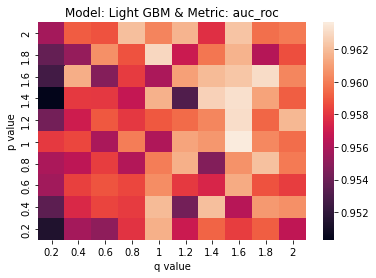

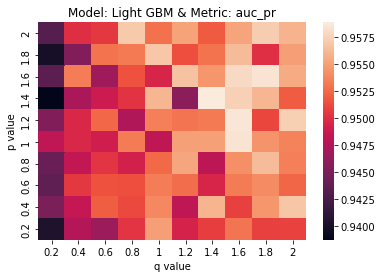

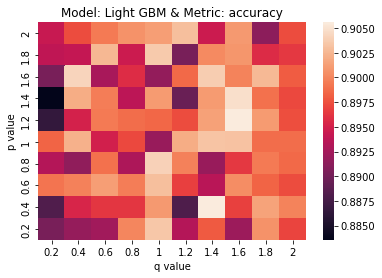

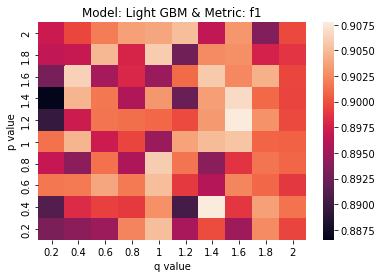

In [28]:
ylabels = [2, 1.8, 1.6, 1.4, 1.2, 1, 0.8, 0.6, 0.4, 0.2]
xlabels = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
data_gbm = result_df[ result_df['model'] == 'Light GBM'].reset_index(drop = True)

for metric in ['auc_roc','auc_pr','accuracy','f1']:
    result_gbm = np.zeros(shape = (10,10))

    for i in range(len(data_gbm)):
        result_gbm[9 - int(data_gbm.loc[i,'p']*5 - 1), int(data_gbm.loc[i,'q']*5 - 1)] = data_gbm.loc[i,metric]

    ax = sns.heatmap(result_gbm, xticklabels = xlabels, yticklabels = ylabels)
    ax.set(xlabel='q value', ylabel='p value')
    plt.title('Model: Light GBM & Metric: '+ metric)
    plt.show()